### Дипломная работа Н.В.Чепурных, студент курса "Аналитик данных"
### Научный руководитель: Алексей Кузьмин
Тема: прогнозирование ежемесячного потребления электрической энергии физическими лицами в электросетевой компании.

Этапы работ:
- Этап 1. Загрузка и объединение данных
- Этап 2. Обработка данных
- Этап 3. Применение модели Линейной регрессии
- Этап 4. Анализ данных, выбросы
- Этап 5. Модель "Случайный лес"
- Этап 6. Применение наиболее точных данных по потреблению с приборов учета, информацию по которым собирается удаленно системой опроса
- Этап 7. Изменение параметров модели "Случайный лес"
- Этап 8. Добавление 2-х новых признаков - потребление за 2019 год и последний месяц. Построение и оптимизация моделей.

### Планы:
- подумать над моделями кусочно - линейной регрессии, градиентного бустинга;
- возможно загрузить еще данные за 2018 год.

Загрузка библиотек:

In [51]:
import os
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

### Этап 1. Загрузка и объединение данных

1.1. Загрузка данных по полезному отпуску электроэнергии за период 2019-2020

In [52]:
%%time
dirName = './Data/Supply/'
supply_all = []
for name in os.listdir(dirName):
    fullname = os.path.join(dirName, name) # получаем полное имя
    if os.path.isfile(fullname):
        df = pd.read_excel(fullname)
        print ("Обработан файл:", fullname, " - загружено строк:", len(df))
        supply_all.append(df)
supply_temp = pd.concat(supply_all,axis=0,ignore_index=True)
print("Всего строк загружено: ", len(supply_temp))

Обработан файл: ./Data/Supply/2019 01.xlsx  - загружено строк: 361365
Обработан файл: ./Data/Supply/2019 02.xlsx  - загружено строк: 361384
Обработан файл: ./Data/Supply/2019 03.xlsx  - загружено строк: 361888
Обработан файл: ./Data/Supply/2019 04.xlsx  - загружено строк: 368771
Обработан файл: ./Data/Supply/2019 05.xlsx  - загружено строк: 373635
Обработан файл: ./Data/Supply/2019 06.xlsx  - загружено строк: 377873
Обработан файл: ./Data/Supply/2019 07.xlsx  - загружено строк: 377808
Обработан файл: ./Data/Supply/2019 08.xlsx  - загружено строк: 376587
Обработан файл: ./Data/Supply/2019 09.xlsx  - загружено строк: 374118
Обработан файл: ./Data/Supply/2019 10.xlsx  - загружено строк: 379904
Обработан файл: ./Data/Supply/2019 11.xlsx  - загружено строк: 375713
Обработан файл: ./Data/Supply/2019 12.xlsx  - загружено строк: 370133
Обработан файл: ./Data/Supply/2020 01.xlsx  - загружено строк: 360223
Обработан файл: ./Data/Supply/2020 02.xlsx  - загружено строк: 362710
Обработан файл: ./Da

In [53]:
supply_temp

,Method,Consumer,Building,Supply,Status,Period
0,ЛС-СДСД,66700000233,дача,0.0,неоспар.,01-2019
1,ЛС-СДСД,66700000410,дача,0.0,неоспар.,01-2019
2,ЛС-СДСД,66700000431,част. ж/дом,2.0,неоспар.,01-2019
3,ЛС-СДСД,66700000557,дача,2.0,неоспар.,01-2019
4,ЛС-СДСД,66700000575,дача,21.0,неоспар.,01-2019
...,...,...,...,...,...,...
5545974,ЛС-ЭНОРМ,69198110501,дача,0.0,неоспар.,03-2020
5545975,ЛС-ЭНОРМ,69198110514,дача,145.0,неоспар.,03-2020
5545976,ЛС-ЭНОРМ,69198110624,дача,145.0,неоспар.,03-2020
5545977,ЛС-ЭНОРМ,69198110718,дача,145.0,неоспар.,03-2020


1.2. Загрузка данных по погоде с 2018 года  по апрель 2020 года.

Сайт с архивом погоды: https://rp5.ru/%D0%90%D1%80%D1%85%D0%B8%D0%B2_%D0%BF%D0%BE%D0%B3%D0%BE%D0%B4%D1%8B_%D0%B2_%D0%9F%D0%B5%D1%80%D0%BC%D0%B8,_%D0%91%D0%BE%D0%BB%D1%8C%D1%88%D0%BE%D0%BC_%D0%A1%D0%B0%D0%B2%D0%B8%D0%BD%D0%BE_(%D0%B0%D1%8D%D1%80%D0%BE%D0%BF%D0%BE%D1%80%D1%82),_METAR

In [54]:
%%time
dirName = './Data/'
name = 'perm_weather_2018.csv'
fullname = os.path.join(dirName, name) # получаем полное имя
if os.path.isfile(fullname):
    weather_temp = pd.read_csv(fullname, sep = ';', encoding = "ISO-8859-1", engine='python')
    print ("Обработан файл:", fullname, " - загружено строк:", len(weather_temp))
else: 
    print ("Ошибка загрузки:", fullname)

Обработан файл: ./Data/perm_weather_2018.csv  - загружено строк: 39987
Wall time: 135 ms


In [55]:
weather_temp.head()

,local time Perm,T
0,28.04.2020 23:30,8.0
1,28.04.2020 23:00,8.0
2,28.04.2020 22:30,8.0
3,28.04.2020 22:00,8.0
4,28.04.2020 21:30,8.0


Преобразовываем строковый параметр к виду mm-yyyy и группируем по месяцам. Получаем среднемесячную температуру.

In [56]:
weather_temp['local time Perm'] = weather_temp['local time Perm'].str.extract('(\d{2}.\d{2}.\d{4})')
weather_temp['local time Perm'] = weather_temp['local time Perm'].str.replace(r'^...','').str.replace('.','-')

In [57]:
weather = weather_temp.groupby('local time Perm').agg({'T': 'mean'}).reset_index()
weather.head()

,local time Perm,T
0,01-2018,-11.211210
1,01-2019,-11.163823
2,01-2020,-6.307012
3,02-2018,-12.592873
4,02-2019,-9.677711


Добавляем среднемесячную температуру в датасет supply

In [58]:
supply = supply_temp.merge(weather, how = 'left', left_on='Period', right_on='local time Perm')
supply.drop(['local time Perm'],axis=1, inplace=True)
supply.head()

,Method,Consumer,Building,Supply,Status,Period,T
0,ЛС-СДСД,66700000233,дача,0.0,неоспар.,01-2019,-11.163823
1,ЛС-СДСД,66700000410,дача,0.0,неоспар.,01-2019,-11.163823
2,ЛС-СДСД,66700000431,част. ж/дом,2.0,неоспар.,01-2019,-11.163823
3,ЛС-СДСД,66700000557,дача,2.0,неоспар.,01-2019,-11.163823
4,ЛС-СДСД,66700000575,дача,21.0,неоспар.,01-2019,-11.163823


1.3. Загружаем данные по потребителям: количество комнат и количество проживающих

In [59]:
%%time
dirName = './Data/'
name = 'RoomsPeoples.xlsx'
fullname = os.path.join(dirName, name) # получаем полное имя
if os.path.isfile(fullname):
    RoomsPeoples = pd.read_excel(fullname)
    print ("Обработан файл:", fullname, " - загружено строк:", len(RoomsPeoples))
else: 
    print ("Ошибка загрузки:", fullname)

Обработан файл: ./Data/RoomsPeoples.xlsx  - загружено строк: 397671
Wall time: 23.2 s


In [60]:
RoomsPeoples.head()

,Consumer,Rooms,Peoples
0,62800121655,1.0,1.0
1,62840754350,1.0,1.0
2,00003,1.0,1.0
3,61007104593,1.0,1.0
4,61009048247,NaN,1.0


Добавляем информацию в датасет supply

In [61]:
supply = supply.merge(RoomsPeoples, how = 'left', left_on='Consumer', right_on='Consumer')
supply.head()

,Method,Consumer,Building,Supply,Status,Period,T,Rooms,Peoples
0,ЛС-СДСД,66700000233,дача,0.0,неоспар.,01-2019,-11.163823,1.0,1.0
1,ЛС-СДСД,66700000410,дача,0.0,неоспар.,01-2019,-11.163823,1.0,1.0
2,ЛС-СДСД,66700000431,част. ж/дом,2.0,неоспар.,01-2019,-11.163823,1.0,1.0
3,ЛС-СДСД,66700000557,дача,2.0,неоспар.,01-2019,-11.163823,1.0,1.0
4,ЛС-СДСД,66700000575,дача,21.0,неоспар.,01-2019,-11.163823,1.0,1.0


1.4. Загружаем данные по категориям потребителей из каталога /Data/Group/

In [62]:
%%time
dirName = './Data/Group/'
group_all = []
for name in os.listdir(dirName):
    fullname = os.path.join(dirName, name) # получаем полное имя
    if os.path.isfile(fullname):
        dfg = pd.read_excel(fullname)
        print ("Обработан файл:", fullname, " - загружено строк:", len(dfg))
        group_all.append(dfg)
group_temp = pd.concat(group_all,axis=0,ignore_index=True)
print("Всего строк загружено: ", len(group_temp))

Обработан файл: ./Data/Group/bes_filtered.xlsx  - загружено строк: 47614
Обработан файл: ./Data/Group/ces_filtered.xlsx  - загружено строк: 103516
Обработан файл: ./Data/Group/chaes_filtered.xlsx  - загружено строк: 83823
Обработан файл: ./Data/Group/chues_filtered.xlsx  - загружено строк: 28754
Обработан файл: ./Data/Group/kues_filtered.xlsx  - загружено строк: 80955
Обработан файл: ./Data/Group/oches_filtered.xlsx  - загружено строк: 63447
Обработан файл: ./Data/Group/pges_filtered.xlsx  - загружено строк: 101690
Обработан файл: ./Data/Group/ses_filtered.xlsx  - загружено строк: 42740
Всего строк загружено:  552539
Wall time: 21.5 s


In [63]:
group_temp.head()

,Consumer,Group
0,66700334153,Население сельское
1,66400019149,Население городское
2,66400042245,Население сельское
3,66400042147,Население сельское
4,66400042147,Население сельское


Удаляем дубликаты

In [64]:
group_temp.drop_duplicates(keep='first', inplace=True)
print(len(group_temp))

346300


Добавляем информацию в датасет supply

In [65]:
#supply.drop('Group', axis=1, inplace=True)
supply.head()

,Method,Consumer,Building,Supply,Status,Period,T,Rooms,Peoples
0,ЛС-СДСД,66700000233,дача,0.0,неоспар.,01-2019,-11.163823,1.0,1.0
1,ЛС-СДСД,66700000410,дача,0.0,неоспар.,01-2019,-11.163823,1.0,1.0
2,ЛС-СДСД,66700000431,част. ж/дом,2.0,неоспар.,01-2019,-11.163823,1.0,1.0
3,ЛС-СДСД,66700000557,дача,2.0,неоспар.,01-2019,-11.163823,1.0,1.0
4,ЛС-СДСД,66700000575,дача,21.0,неоспар.,01-2019,-11.163823,1.0,1.0


In [66]:
group_temp['Consumer'] = group_temp['Consumer'].astype(str)
supply = supply.merge(group_temp, how = 'left', left_on='Consumer', right_on='Consumer')
supply.head()

,Method,Consumer,Building,Supply,Status,Period,T,Rooms,Peoples,Group
0,ЛС-СДСД,66700000233,дача,0.0,неоспар.,01-2019,-11.163823,1.0,1.0,Население сельское
1,ЛС-СДСД,66700000410,дача,0.0,неоспар.,01-2019,-11.163823,1.0,1.0,Население сельское
2,ЛС-СДСД,66700000431,част. ж/дом,2.0,неоспар.,01-2019,-11.163823,1.0,1.0,Население сельское
3,ЛС-СДСД,66700000557,дача,2.0,неоспар.,01-2019,-11.163823,1.0,1.0,Население сельское
4,ЛС-СДСД,66700000575,дача,21.0,неоспар.,01-2019,-11.163823,1.0,1.0,Население сельское


### Этап 2. Обработка данных

2.1. Удаляем дубликаты

In [67]:
supply.drop_duplicates(keep='first', inplace=True)
print(len(supply))

5540202


2.2. Удаляем все строки со статусом Status = "оспар.", потом удаляем сам столбец за ненадобностью (он используется при расчетах полезного отпуска)

In [68]:
supply = supply.loc[supply['Status']!='оспар.']
print(len(supply))

5492567


In [69]:
supply.drop('Status', axis=1, inplace=True)
supply.head()

,Method,Consumer,Building,Supply,Period,T,Rooms,Peoples,Group
0,ЛС-СДСД,66700000233,дача,0.0,01-2019,-11.163823,1.0,1.0,Население сельское
1,ЛС-СДСД,66700000410,дача,0.0,01-2019,-11.163823,1.0,1.0,Население сельское
2,ЛС-СДСД,66700000431,част. ж/дом,2.0,01-2019,-11.163823,1.0,1.0,Население сельское
3,ЛС-СДСД,66700000557,дача,2.0,01-2019,-11.163823,1.0,1.0,Население сельское
4,ЛС-СДСД,66700000575,дача,21.0,01-2019,-11.163823,1.0,1.0,Население сельское


Делаем копию основного датасета со столбцом Period, это нам понадобится на этапе 8.

In [71]:
ds_supply = supply.copy()

2.3. Удаляем столбец "Period", т.к. он использовался только для добавления среднемесячной температуры

In [72]:
supply.drop('Period', axis=1, inplace=True)
supply.head()

,Method,Consumer,Building,Supply,T,Rooms,Peoples,Group
0,ЛС-СДСД,66700000233,дача,0.0,-11.163823,1.0,1.0,Население сельское
1,ЛС-СДСД,66700000410,дача,0.0,-11.163823,1.0,1.0,Население сельское
2,ЛС-СДСД,66700000431,част. ж/дом,2.0,-11.163823,1.0,1.0,Население сельское
3,ЛС-СДСД,66700000557,дача,2.0,-11.163823,1.0,1.0,Население сельское
4,ЛС-СДСД,66700000575,дача,21.0,-11.163823,1.0,1.0,Население сельское


2.4. Из столбца "Building" извлекаем данные о том, постоянно ли проживают по данному адресу (не дача) или нет. Добавляем столбец "Permanent_Residence", которое принимает значение 1 при постоянном проживании, и 0 в обратном случае.

In [73]:
supply['Building'].unique()

array(['дача', 'част. ж/дом', 'кварт.', 'баня', 'стр.площ.', 'гараж',
       'кв. малокв.', 'хоз.постр.', 'прочие хоз.', 'мнкв.дом', 'ТП',
       'Не опр.', 'прочие пром.', 'разрушенный', 'нежилой',
       'общест. объект', 'нежилое в мн.кв.', 'нежилая кварт.',
       'водокачка', 'религ. объект', 'общежитие', 'эл.отопл.', 'пилорама',
       'проч. объекты юр.лиц', 'мастерская', 'яма', 'сад',
       'мнкв.авар.дом', 'мнкв.ветх.дом'], dtype=object)

In [74]:
def Permanent_Residence(b):
    perm_list = ['кварт.','част. ж/дом','кв. малокв.','мнкв.дом','общежитие', 'эл.отопл.']
    if b in perm_list:
        return 1
    else:
        return 0

In [75]:
supply['Permanent_Residence'] = supply['Building'].apply(Permanent_Residence)

Удаляем столбец "Building"

In [76]:
supply.drop('Building', axis=1, inplace=True)
supply.head()

,Method,Consumer,Supply,T,Rooms,Peoples,Group,Permanent_Residence
0,ЛС-СДСД,66700000233,0.0,-11.163823,1.0,1.0,Население сельское,0
1,ЛС-СДСД,66700000410,0.0,-11.163823,1.0,1.0,Население сельское,0
2,ЛС-СДСД,66700000431,2.0,-11.163823,1.0,1.0,Население сельское,1
3,ЛС-СДСД,66700000557,2.0,-11.163823,1.0,1.0,Население сельское,0
4,ЛС-СДСД,66700000575,21.0,-11.163823,1.0,1.0,Население сельское,0


2.5. Из столбца "Group" извлекаем данные о том, потребитель сельский или городской. 
Добавляем столбец "City", которое принимает значение 1 при городском расположении, и 0 в обратном случае.

In [77]:
supply['Group'].unique()

array(['Население сельское', 'Население городское', nan,
       'Приравненные к населению (село)',
       'Приравненные к населению (город)', 'Не определено',
       'Непромышленные потребители', 'Промышленные потребители'],
      dtype=object)

In [78]:
def City_Residence(b):
    perm_list = ['Население городское','Приравненные к населению (город)','Непромышленные потребители', 'Промышленные потребители']
    if b in perm_list:
        return 1
    else:
        return 0

In [79]:
supply['City'] = supply['Group'].apply(City_Residence)

Удаляем столбец "Group"

In [80]:
supply.drop('Group', axis=1, inplace=True)
supply.head()

,Method,Consumer,Supply,T,Rooms,Peoples,Permanent_Residence,City
0,ЛС-СДСД,66700000233,0.0,-11.163823,1.0,1.0,0,0
1,ЛС-СДСД,66700000410,0.0,-11.163823,1.0,1.0,0,0
2,ЛС-СДСД,66700000431,2.0,-11.163823,1.0,1.0,1,0
3,ЛС-СДСД,66700000557,2.0,-11.163823,1.0,1.0,0,0
4,ЛС-СДСД,66700000575,21.0,-11.163823,1.0,1.0,0,0


2.6. Из столбца "Consumer" удаляем всех потребителей, у которых договор не состоит из одних цифр. 
Эти договоры не имеют отношение к населению.

In [81]:
supply[supply['Consumer'].str.contains('\D+',flags=re.IGNORECASE, regex=True)]

,Method,Consumer,Supply,T,Rooms,Peoples,Permanent_Residence,City
2265,ЛС-КПП,ОДУ У Беляева 26,0.0,-11.163823,NaN,NaN,1,0
9654,ЛС-КПБ,МКД ЮГ без УК,0.0,-11.163823,2.0,6.0,0,1
12484,ЛС-НОРМ,МКД СЕВЕР (не определено),0.0,-11.163823,8.0,64.0,0,1
12491,ЛС-НОРМ,МКД СЕВЕР (непосредственное),0.0,-11.163823,2.0,2.0,0,1
12496,ЛС-НОРМ,МКД ЮГ без УК,0.0,-11.163823,2.0,6.0,0,1
...,...,...,...,...,...,...,...,...
5490340,ЛС-ЭКП,65300004805,1250.0,0.552076,8.0,4.0,1,0
5505648,ЛС-СДСД,3+ОДПУ,1951.0,0.552076,16.0,16.0,1,1
5505649,ЛС-СДСД,3836 ОДПУ,293.0,0.552076,0.0,3.0,1,1
5538945,ЛС-НОРМ,для з/д,145.0,0.552076,12.0,17.0,1,1


In [82]:
supply = supply[~supply['Consumer'].str.contains('\D+',flags=re.IGNORECASE, regex=True)]

2.7. Проверяем на пустые значения и заполняем данными

In [83]:
supply.isnull().sum()

Method                      0
Consumer                    0
Supply                      0
T                           0
Rooms                  196913
Peoples                189959
Permanent_Residence         0
City                        0
dtype: int64

In [84]:
supply.describe()

,Supply,T,Rooms,Peoples,Permanent_Residence,City
count,5.488323e+06,5.488323e+06,5.291410e+06,5.298364e+06,5.488323e+06,5.488323e+06
mean,2.385289e+02,2.329030e+00,1.575323e+00,2.123765e+00,8.560313e-01,2.752804e-01
std,8.715553e+02,9.297464e+00,1.170233e+00,1.659900e+00,3.510581e-01,4.466555e-01
min,-4.572060e+05,-1.116382e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.300000e+01,-6.255830e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
50%,1.420000e+02,5.520762e-01,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
75%,2.500000e+02,1.340122e+01,2.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00
max,3.280420e+05,1.713523e+01,5.100000e+01,7.700000e+01,1.000000e+00,1.000000e+00


Для поля "Rooms" ставим среднее округленное значение 2.0, для поля "Peoples" значение 2.0

In [85]:
supply.fillna(value={'Rooms': 2, 'Peoples': 2}, inplace=True)
supply.head()

,Method,Consumer,Supply,T,Rooms,Peoples,Permanent_Residence,City
0,ЛС-СДСД,66700000233,0.0,-11.163823,1.0,1.0,0,0
1,ЛС-СДСД,66700000410,0.0,-11.163823,1.0,1.0,0,0
2,ЛС-СДСД,66700000431,2.0,-11.163823,1.0,1.0,1,0
3,ЛС-СДСД,66700000557,2.0,-11.163823,1.0,1.0,0,0
4,ЛС-СДСД,66700000575,21.0,-11.163823,1.0,1.0,0,0


In [86]:
supply.isnull().sum()

Method                 0
Consumer               0
Supply                 0
T                      0
Rooms                  0
Peoples                0
Permanent_Residence    0
City                   0
dtype: int64

Теперь создаем копию датасета под именем ds_work, с ним работаем дальше. А в датасете supply остается полная копия данных, к которым можно вернуться, если надо будет изменять модель и добавлять новые признаки.

In [87]:
ds_work = supply.copy()
ds_work.head()

,Method,Consumer,Supply,T,Rooms,Peoples,Permanent_Residence,City
0,ЛС-СДСД,66700000233,0.0,-11.163823,1.0,1.0,0,0
1,ЛС-СДСД,66700000410,0.0,-11.163823,1.0,1.0,0,0
2,ЛС-СДСД,66700000431,2.0,-11.163823,1.0,1.0,1,0
3,ЛС-СДСД,66700000557,2.0,-11.163823,1.0,1.0,0,0
4,ЛС-СДСД,66700000575,21.0,-11.163823,1.0,1.0,0,0


Удаляем из датасета ds_work столбец Method, т.к. этот столбец будет нужен для более тонкой настройки модели. Если прямой подход "в лоб" не сработает.

In [88]:
ds_work.drop('Method', axis=1, inplace=True)
ds_work.head()

,Consumer,Supply,T,Rooms,Peoples,Permanent_Residence,City
0,66700000233,0.0,-11.163823,1.0,1.0,0,0
1,66700000410,0.0,-11.163823,1.0,1.0,0,0
2,66700000431,2.0,-11.163823,1.0,1.0,1,0
3,66700000557,2.0,-11.163823,1.0,1.0,0,0
4,66700000575,21.0,-11.163823,1.0,1.0,0,0


In [89]:
ds_work.drop('Consumer', axis=1, inplace=True)
ds_work.head()

,Supply,T,Rooms,Peoples,Permanent_Residence,City
0,0.0,-11.163823,1.0,1.0,0,0
1,0.0,-11.163823,1.0,1.0,0,0
2,2.0,-11.163823,1.0,1.0,1,0
3,2.0,-11.163823,1.0,1.0,0,0
4,21.0,-11.163823,1.0,1.0,0,0


### Этап 3. Применение модели Линейной регрессии

In [90]:
X_train, X_test, y_train, y_test = train_test_split(ds_work[['T', 'Rooms', 'Peoples', 'Permanent_Residence','City']], ds_work['Supply'], test_size=0.3)

In [91]:
model = LinearRegression()

In [92]:
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Оценим качество модели

In [93]:
r_train = model.score(X_train, y_train)
r_test = model.score(X_test, y_test)
print('Качество модели на тестовых данных:', r_test, '\nКачество модели на тренировочных данных:', r_train)

Качество модели на тестовых данных: 0.0038600506864181483 
Качество модели на тренировочных данных: 0.0037110739540193727


In [94]:
model_pred = model.predict(X_test)
# print('R2 score:', model.r2_score(y_test, model_pred))

### Абсолютно неудовлетворительное качество модели

### Этап 4. Анализ данных, выбросы

In [95]:
ds_work.describe()

,Supply,T,Rooms,Peoples,Permanent_Residence,City
count,5.488323e+06,5.488323e+06,5.488323e+06,5.488323e+06,5.488323e+06,5.488323e+06
mean,2.385289e+02,2.329030e+00,1.590560e+00,2.119481e+00,8.560313e-01,2.752804e-01
std,8.715553e+02,9.297464e+00,1.151760e+00,1.631078e+00,3.510581e-01,4.466555e-01
min,-4.572060e+05,-1.116382e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.300000e+01,-6.255830e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
50%,1.420000e+02,5.520762e-01,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
75%,2.500000e+02,1.340122e+01,2.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00
max,3.280420e+05,1.713523e+01,5.100000e+01,7.700000e+01,1.000000e+00,1.000000e+00


4.1. Устранение выбросов

Для устранения выбросов интересны:
- признак Supply(полезный отпуск электроэнергии): следует убрать отрицательные значения (они говорят о корректировке ранее неправильно введенных данных), нулевые значения (в этот период или показания не снимались у потребителя, или расчет полезного отпуска был проведен по нулевым данным), значения свыше 5 тыс.(это может говорить либо о сильном электропотреблении зимой у коттеджей, либо о расчете полезного отпуска не за 1 месяц, а, например, за год)
- признак Peoples(люди): максимум в 77 человек говорит о том, что возможно попало немного данных не по физическим лицам, а по многоквартирным домам, их надо убрать;
- признак R(комнаты): максимум в 51 комнату говорит о том, что возможно попало немного данных не по физическим лицам, а по многоквартирным домам, их надо убрать;
- признаки T(температура), , Permanent_Residence(постоянное проживание) и City(город) не имеют выбросов.

In [96]:
print(len(ds_work[ds_work['Supply'] <1]), len(ds_work[ds_work['Supply'] == 0]), len(ds_work[ds_work['Supply'] > 5000]))

774259 542538 13040


In [97]:
ds_work = ds_work[ds_work['Supply'] >=1]
ds_work = ds_work[ds_work['Supply'] <5000]

In [98]:
ds_work = ds_work[ds_work['Peoples'] <10]
ds_work = ds_work[ds_work['Rooms'] <10]

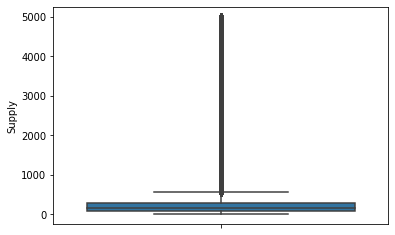

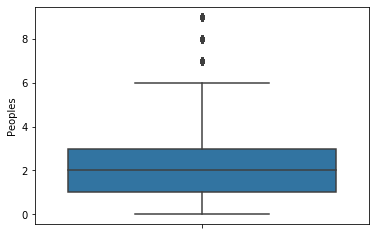

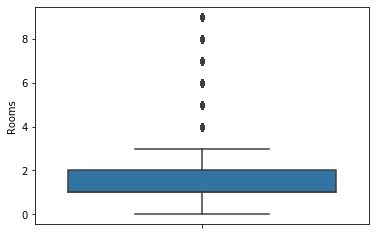

In [99]:
#plt.figure(figsize=(6,6))
sns.boxplot(y="Supply", data=ds_work)
plt.show()
sns.boxplot(y="Peoples", data=ds_work)
plt.show()
sns.boxplot(y="Rooms", data=ds_work)
plt.show()

In [100]:
ds_work.describe()

,Supply,T,Rooms,Peoples,Permanent_Residence,City
count,4.673311e+06,4.673311e+06,4.673311e+06,4.673311e+06,4.673311e+06,4.673311e+06
mean,2.700694e+02,2.463591e+00,1.602845e+00,2.133927e+00,8.825223e-01,2.850846e-01
std,4.226096e+02,9.327202e+00,1.075914e+00,1.485112e+00,3.219887e-01,4.514548e-01
min,1.000000e+00,-1.116382e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.700000e+01,-6.255830e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
50%,1.540000e+02,5.520762e-01,1.000000e+00,2.000000e+00,1.000000e+00,0.000000e+00
75%,2.790000e+02,1.340122e+01,2.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00
max,4.999000e+03,1.713523e+01,9.000000e+00,9.000000e+00,1.000000e+00,1.000000e+00


4.2. Матрица корреляций

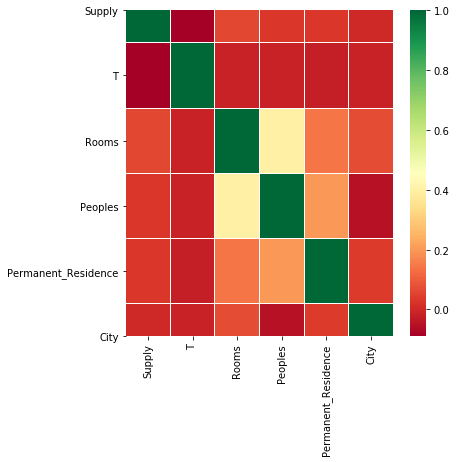

In [101]:
f, ax = plt.subplots(figsize=(6, 6))
corr = np.round_(ds_work.corr(), decimals=2)
sns.heatmap(corr,annot=False,cmap='RdYlGn',linewidths=0.2)

Корреляция между признаками выражена слабо, только комнаты и люди коррелируют, но это было ожидаемо - чем больше людей живет, тем больше комнат требуется.

4.3. Визуализация взаимосвязей между признаками

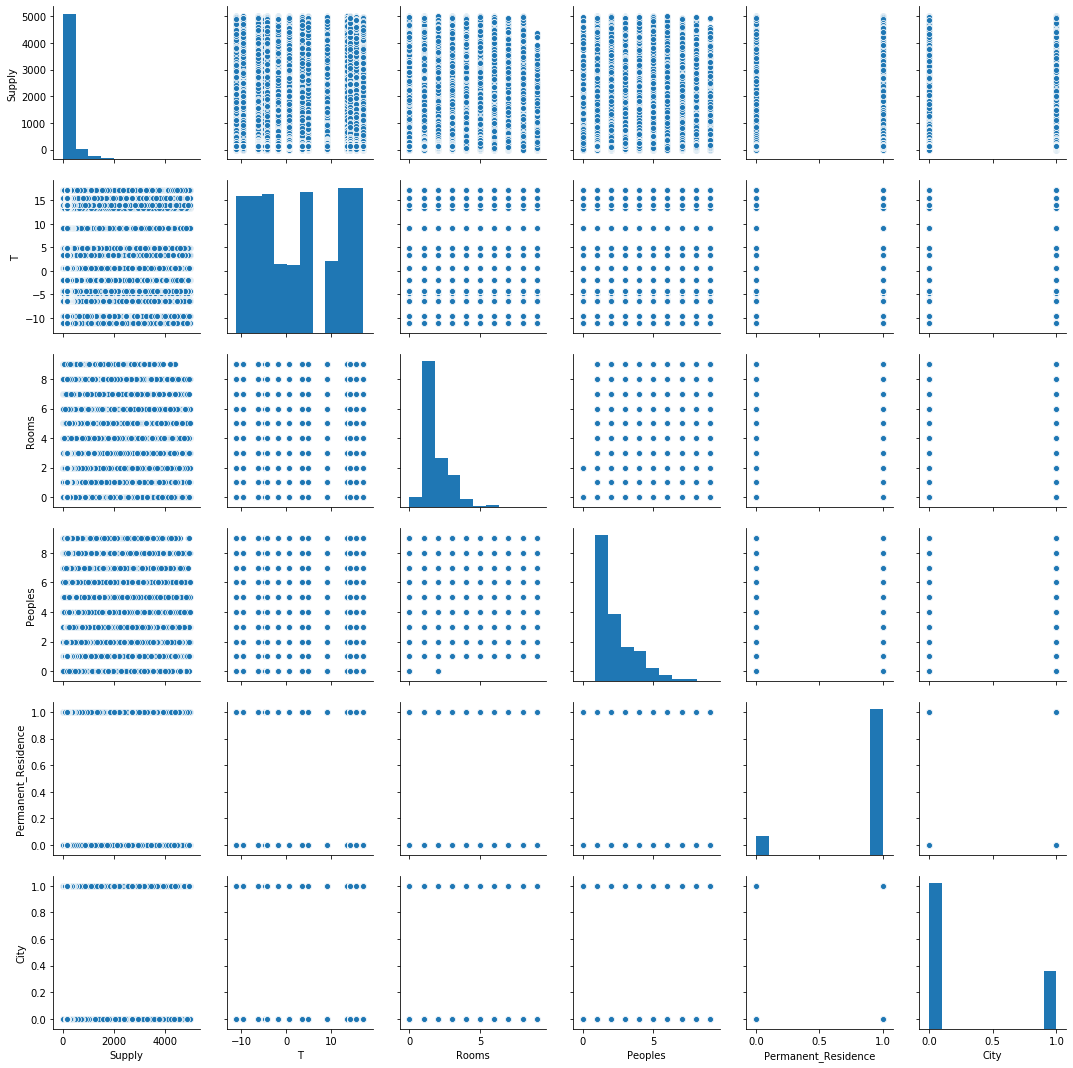

In [105]:
sns.pairplot(ds_work)
plt.show()

Этап 5. Модель "Random forest"

Теперь на очищенных данных применяем снова модель линейной регрессии и модель случайного леса.

5.1. Линейная регрессия

In [106]:
X_train, X_test, y_train, y_test = train_test_split(ds_work[['T', 'Rooms', 'Peoples', 'Permanent_Residence','City']], ds_work['Supply'], test_size=0.3)
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [107]:
r_train = model.score(X_train, y_train)
r_test = model.score(X_test, y_test)
print('Качество модели на тестовых данных:', r_test, '\nКачество модели на тренировочных данных:', r_train)

Качество модели на тестовых данных: 0.012051244429228114 
Качество модели на тренировочных данных: 0.01185331046420024


In [108]:
model_pred = model.predict(X_test)
# print('R2 score:', model.r2_score(y_test, model_pred))

Качество модели на очищенных данных увеличилось в 3 раза, но все-равно остается на неудовлетворительном уровне.

5.2. Случайный лес

In [109]:
X_train, X_test, y_train, y_test = train_test_split(ds_work[['T', 'Rooms', 'Peoples', 'Permanent_Residence','City']], ds_work['Supply'], test_size=0.3)
model_rf=RandomForestRegressor(n_estimators=100, max_features='auto', n_jobs=4, random_state=1)
model_rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=4, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

In [110]:
model_pred = model_rf.predict(X_test)
print('Mean Absolute Error (MAE):', mean_absolute_error(y_test, model_pred))
print('Mean Squared Error (MSE):', mean_squared_error(y_test, model_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(y_test, model_pred)))
mape = np.mean(np.abs((y_test - model_pred) / np.abs(y_test)))
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
print('Accuracy:', round(100*(1 - mape), 2))
print('Model score:', model_rf.score(X_test, y_test))

Mean Absolute Error (MAE): 214.79302012908806
Mean Squared Error (MSE): 174126.57155252685
Root Mean Squared Error (RMSE): 417.28476074801347
Mean Absolute Percentage Error (MAPE): 748.18
Accuracy: -648.18
Model score: 0.023765456698270238


Наиболее важные признаки:

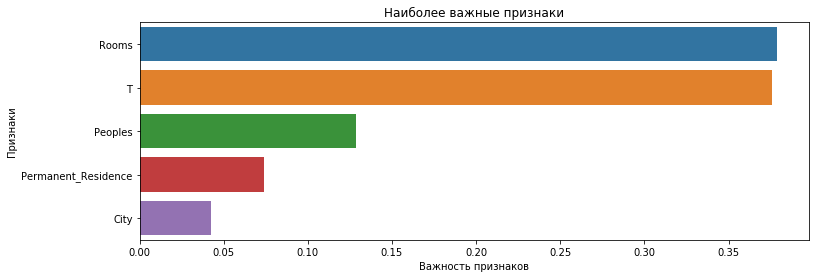

In [111]:
headers = list(X_train.columns.values)
feature_imp = pd.Series(model_rf.feature_importances_,index=headers).sort_values(ascending=False)
f, ax = plt.subplots(figsize=(12, 4))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Важность признаков')
plt.ylabel('Признаки')
plt.title("Наиболее важные признаки")
plt.show()

### Этап 6. Применение наиболее точных данных по потреблению с приборов учета, информацию по которым собирается удаленно системой опроса

Создаем вторую копию датасета supply под именем ds_sdsd, с ним работаем дальше. 
В этот датасет помещаем наиболее точные данные с приборов учета.

In [112]:
ds_sdsd = supply.copy()
ds_sdsd = ds_sdsd[ds_sdsd['Method']=='ЛС-СДСД']

In [113]:
ds_sdsd.drop('Method', axis=1, inplace=True)
ds_sdsd.drop('Consumer', axis=1, inplace=True)
ds_sdsd.head()

,Supply,T,Rooms,Peoples,Permanent_Residence,City
0,0.0,-11.163823,1.0,1.0,0,0
1,0.0,-11.163823,1.0,1.0,0,0
2,2.0,-11.163823,1.0,1.0,1,0
3,2.0,-11.163823,1.0,1.0,0,0
4,21.0,-11.163823,1.0,1.0,0,0


Устраняем выбросы

In [114]:
ds_sdsd = ds_sdsd[ds_sdsd['Supply'] >=1]
ds_sdsd = ds_sdsd[ds_sdsd['Supply'] <5000]
ds_sdsd = ds_sdsd[ds_sdsd['Peoples'] <10]
ds_sdsd = ds_sdsd[ds_sdsd['Rooms'] <10]

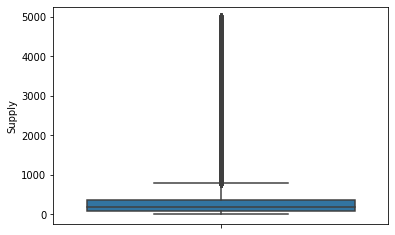

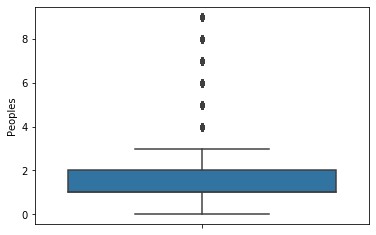

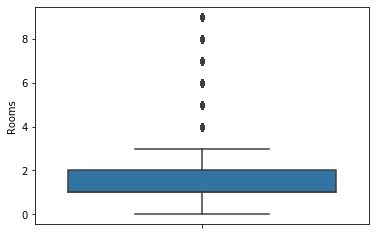

In [115]:
sns.boxplot(y="Supply", data=ds_sdsd)
plt.show()
sns.boxplot(y="Peoples", data=ds_sdsd)
plt.show()
sns.boxplot(y="Rooms", data=ds_sdsd)
plt.show()

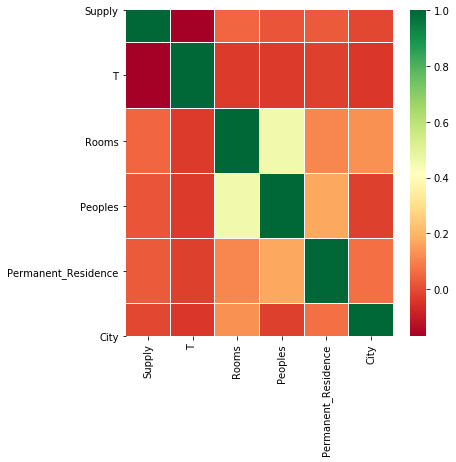

In [116]:
f, ax = plt.subplots(figsize=(6, 6))
corr = np.round_(ds_sdsd.corr(), decimals=2)
sns.heatmap(corr,annot=False,cmap='RdYlGn',linewidths=0.2)

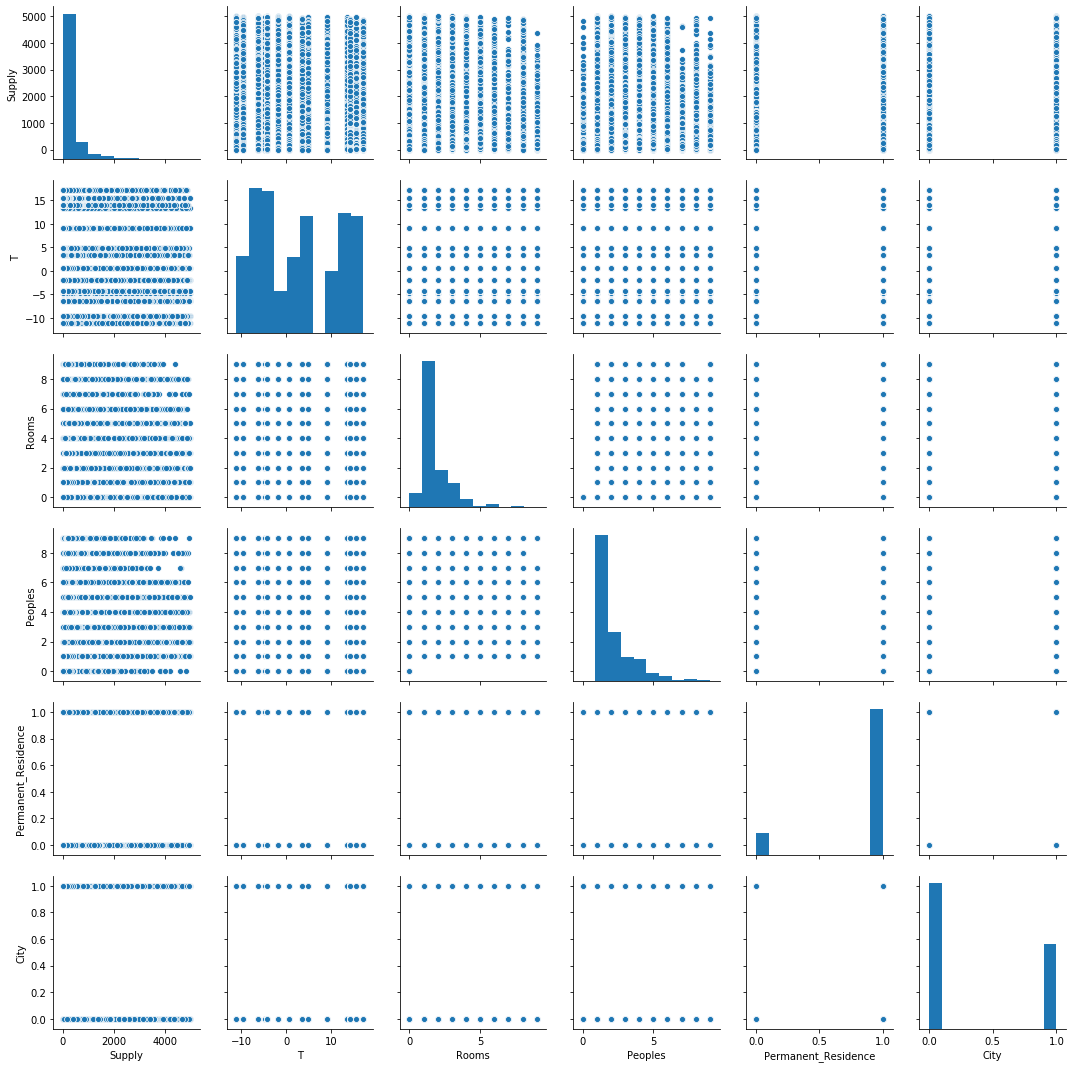

In [117]:
sns.pairplot(ds_sdsd)
plt.show()

Линейная регрессия

In [118]:
X_train, X_test, y_train, y_test = train_test_split(ds_sdsd[['T', 'Rooms', 'Peoples', 'Permanent_Residence','City']], ds_sdsd['Supply'], test_size=0.3)
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [119]:
r_train = model.score(X_train, y_train)
r_test = model.score(X_test, y_test)
print('Качество модели на тестовых данных:', r_test, '\nКачество модели на тренировочных данных:', r_train)

Качество модели на тестовых данных: 0.033508716824920404 
Качество модели на тренировочных данных: 0.032971484988375765


Выводы: результаты от модели на полных данных отличаются: выросли с 0,012 до 0.033. 

Можно выдвинуть гипотезу, что дело в неподходящей модели.

Случайный лес

In [120]:
X_train, X_test, y_train, y_test = train_test_split(ds_sdsd[['T', 'Rooms', 'Peoples', 'Permanent_Residence','City']], ds_sdsd['Supply'], test_size=0.3)
model_rf=RandomForestRegressor(n_estimators=100, max_features='auto', n_jobs=4, random_state=1)
model_rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=4, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

In [121]:
model_pred = model_rf.predict(X_test)
print('Mean Absolute Error (MAE):', mean_absolute_error(y_test, model_pred))
print('Mean Squared Error (MSE):', mean_squared_error(y_test, model_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(y_test, model_pred)))
mape = np.mean(np.abs((y_test - model_pred) / np.abs(y_test)))
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
print('Accuracy:', round(100*(1 - mape), 2))
print('Model score:', model_rf.score(X_test, y_test))

Mean Absolute Error (MAE): 304.52250547545725
Mean Squared Error (MSE): 277832.3094979421
Root Mean Squared Error (RMSE): 527.0980074881161
Mean Absolute Percentage Error (MAPE): 1711.59
Accuracy: -1611.59
Model score: 0.04207995558241184


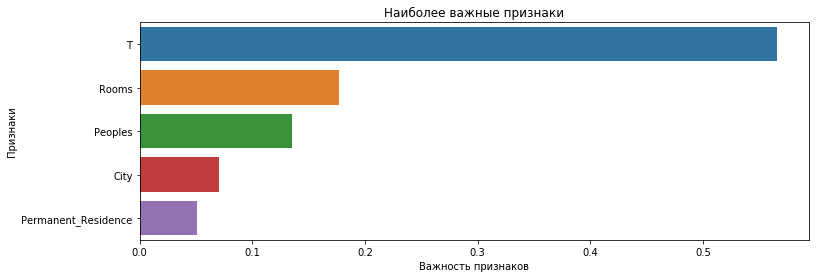

In [122]:
headers = list(X_train.columns.values)
feature_imp = pd.Series(model_rf.feature_importances_,index=headers).sort_values(ascending=False)
f, ax = plt.subplots(figsize=(12, 4))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Важность признаков')
plt.ylabel('Признаки')
plt.title("Наиболее важные признаки")
plt.show()

Выводы: 
- Mean Absolute Error (MAE): 305 (было на полной модели: 215)
- Mean Squared Error (MSE): 281476 (174962)
- Root Mean Squared Error (RMSE): 530 (418)
- Mean Absolute Percentage Error (MAPE): 1695 (749)
- Accuracy: -1595 (-649)
- Model score: 0.041 (0.024)

Общий вывод при применении наиболее точных данных в модели: точность модели не улучшилась. 

Надо подобрать параметры модели и посмотреть на результат.

### Этап 7. Изменение параметров модели "Случайный лес"

Влияние параметра n_estimators

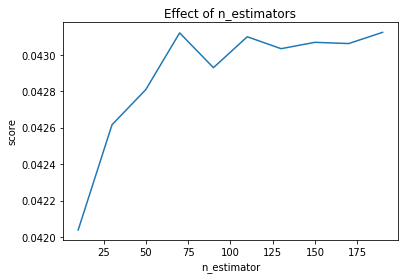

In [123]:
X_train, X_test, y_train, y_test = train_test_split(ds_sdsd[['T', 'Rooms', 'Peoples', 'Permanent_Residence','City']], ds_sdsd['Supply'], test_size=0.3)
model_test=RandomForestRegressor()
estimators = np.arange(10, 200, 20)
scores = []
for n in estimators:
    model_test.set_params(n_estimators=n)
    model_test.fit(X_train, y_train)
    scores.append(model_test.score(X_test, y_test))
plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("score")
plt.plot(estimators, scores)

Влияние параметра max_features

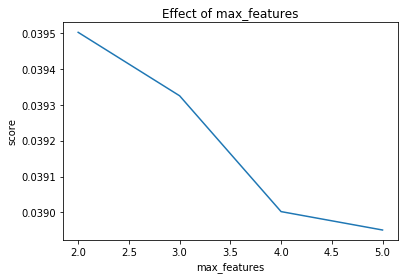

In [124]:
X_train, X_test, y_train, y_test = train_test_split(ds_sdsd[['T', 'Rooms', 'Peoples', 'Permanent_Residence','City']], ds_sdsd['Supply'], test_size=0.3)
model_test=RandomForestRegressor()
features = np.arange(2, 6, 1)
scores = []
for f in features:
    model_test.set_params(n_estimators=125, max_features=f)
    model_test.fit(X_train, y_train)
    scores.append(model_test.score(X_test, y_test))
plt.title("Effect of max_features")
plt.xlabel("max_features")
plt.ylabel("score")
plt.plot(features, scores)

### Этап 8. Добавление 2-х новых признаков - потребление за 2019 год и последний месяц. Построение и оптимизация моделей

Для добавления признаков создаем датасет ds_sum, который является группировкой общего датасета ds_supply по потреблению за 2019 год, и датасет ds_month по последнему месяцу (март 2020 года).

In [125]:
ds_supply.head()

,Method,Consumer,Building,Supply,Period,T,Rooms,Peoples,Group
0,ЛС-СДСД,66700000233,дача,0.0,01-2019,-11.163823,1.0,1.0,Население сельское
1,ЛС-СДСД,66700000410,дача,0.0,01-2019,-11.163823,1.0,1.0,Население сельское
2,ЛС-СДСД,66700000431,част. ж/дом,2.0,01-2019,-11.163823,1.0,1.0,Население сельское
3,ЛС-СДСД,66700000557,дача,2.0,01-2019,-11.163823,1.0,1.0,Население сельское
4,ЛС-СДСД,66700000575,дача,21.0,01-2019,-11.163823,1.0,1.0,Население сельское


In [171]:
ds_supply[ds_supply['Period'].str.contains('2019')]['Period'].unique()

array(['01-2019', '02-2019', '03-2019', '04-2019', '05-2019', '06-2019',
       '07-2019', '08-2019', '09-2019', '10-2019', '11-2019', '12-2019'],
      dtype=object)

In [176]:
ds_sum = ds_supply[ds_supply['Period'].str.contains('2019')].groupby('Consumer').agg({'Supply': 'sum'}).rename(columns={'Supply': '2019'}).reset_index()


In [177]:
ds_sum.head()

,Consumer,2019
0,000001,512.0
1,000002,9334.0
2,00003,846549.0
3,00006,180050.0
4,0130,37470.0


In [180]:
ds_month = ds_supply[ds_supply['Period'].str.contains('03-2020')].groupby('Consumer').agg({'Supply': 'sum'}).rename(columns={'Supply': 'LastMonth'}).reset_index()

In [181]:
ds_month.head()

,Consumer,LastMonth
0,000001,64.0
1,069101010004,0.0
2,069106057057,0.0
3,1113701304,168.0
4,1113701344,54.0


Заново создаем рабочий датасет ds_sdsd_2 с добавлением 2-х признаков - потребление за 2019 год и последний месяц. 

In [187]:
ds_supply.drop('Period', axis=1, inplace=True)
ds_supply['Permanent_Residence'] = ds_supply['Building'].apply(Permanent_Residence)
ds_supply.drop('Building', axis=1, inplace=True)
ds_supply['City'] = ds_supply['Group'].apply(City_Residence)
ds_supply.drop('Group', axis=1, inplace=True)
ds_supply = ds_supply[~ds_supply['Consumer'].str.contains('\D+',flags=re.IGNORECASE, regex=True)]

In [188]:
ds_supply.fillna(value={'Rooms': 2, 'Peoples': 2}, inplace=True)
ds_supply.isnull().sum()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


Method                 0
Consumer               0
Supply                 0
T                      0
Rooms                  0
Peoples                0
Permanent_Residence    0
City                   0
dtype: int64

In [189]:
ds_sdsd_2 = ds_supply[ds_supply['Method']=='ЛС-СДСД']

In [190]:
ds_sdsd_2 = ds_sdsd_2.merge(ds_sum, how = 'left', left_on='Consumer', right_on='Consumer')
ds_sdsd_2.head()

,Method,Consumer,Supply,T,Rooms,Peoples,Permanent_Residence,City,2019
0,ЛС-СДСД,66700000233,0.0,-11.163823,1.0,1.0,0,0,174.0
1,ЛС-СДСД,66700000410,0.0,-11.163823,1.0,1.0,0,0,6426.0
2,ЛС-СДСД,66700000431,2.0,-11.163823,1.0,1.0,1,0,1978.0
3,ЛС-СДСД,66700000557,2.0,-11.163823,1.0,1.0,0,0,766.0
4,ЛС-СДСД,66700000575,21.0,-11.163823,1.0,1.0,0,0,903.0


In [191]:
ds_sdsd_2 = ds_sdsd_2.merge(ds_month, how = 'left', left_on='Consumer', right_on='Consumer')
ds_sdsd_2.head()

,Method,Consumer,Supply,T,Rooms,Peoples,Permanent_Residence,City,2019,LastMonth
0,ЛС-СДСД,66700000233,0.0,-11.163823,1.0,1.0,0,0,174.0,0.0
1,ЛС-СДСД,66700000410,0.0,-11.163823,1.0,1.0,0,0,6426.0,1343.0
2,ЛС-СДСД,66700000431,2.0,-11.163823,1.0,1.0,1,0,1978.0,2.0
3,ЛС-СДСД,66700000557,2.0,-11.163823,1.0,1.0,0,0,766.0,1.0
4,ЛС-СДСД,66700000575,21.0,-11.163823,1.0,1.0,0,0,903.0,40.0


In [192]:
ds_sdsd_2.drop('Method', axis=1, inplace=True)
ds_sdsd_2.drop('Consumer', axis=1, inplace=True)
ds_sdsd_2.head()

,Supply,T,Rooms,Peoples,Permanent_Residence,City,2019,LastMonth
0,0.0,-11.163823,1.0,1.0,0,0,174.0,0.0
1,0.0,-11.163823,1.0,1.0,0,0,6426.0,1343.0
2,2.0,-11.163823,1.0,1.0,1,0,1978.0,2.0
3,2.0,-11.163823,1.0,1.0,0,0,766.0,1.0
4,21.0,-11.163823,1.0,1.0,0,0,903.0,40.0


Датасет ds_sdsd_2 сформирован, устраняем снова выбросы

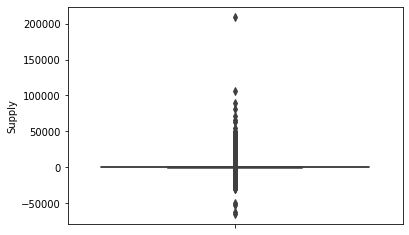

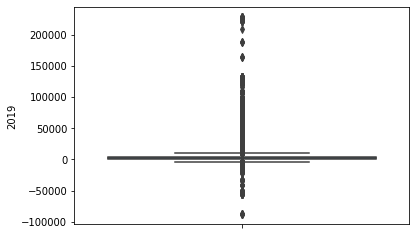

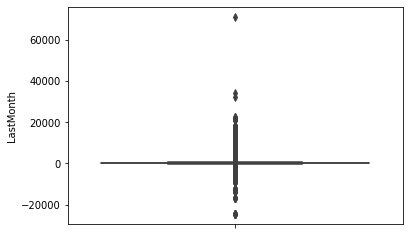

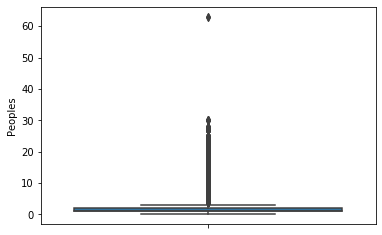

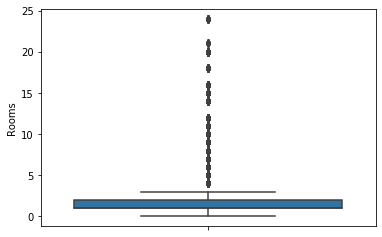

In [194]:
sns.boxplot(y="Supply", data=ds_sdsd_2)
plt.show()
sns.boxplot(y="2019", data=ds_sdsd_2)
plt.show()
sns.boxplot(y="LastMonth", data=ds_sdsd_2)
plt.show()
sns.boxplot(y="Peoples", data=ds_sdsd_2)
plt.show()
sns.boxplot(y="Rooms", data=ds_sdsd_2)
plt.show()

In [199]:
ds_sdsd_2 = ds_sdsd_2[ds_sdsd_2['Supply'] >=1]
ds_sdsd_2 = ds_sdsd_2[ds_sdsd_2['2019'] >=1]
ds_sdsd_2 = ds_sdsd_2[ds_sdsd_2['LastMonth'] >=1]
ds_sdsd_2 = ds_sdsd_2[ds_sdsd_2['Supply'] <5000]
ds_sdsd_2 = ds_sdsd_2[ds_sdsd_2['2019'] <60000]
ds_sdsd_2 = ds_sdsd_2[ds_sdsd_2['LastMonth'] <5000]
ds_sdsd_2 = ds_sdsd_2[ds_sdsd_2['Peoples'] <10]
ds_sdsd_2 = ds_sdsd_2[ds_sdsd_2['Rooms'] <10]

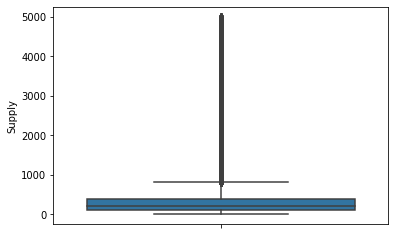

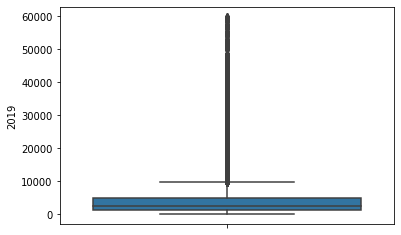

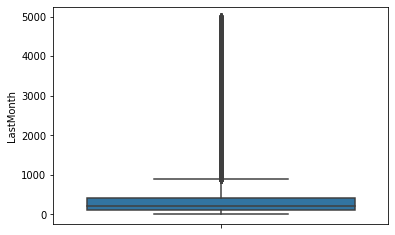

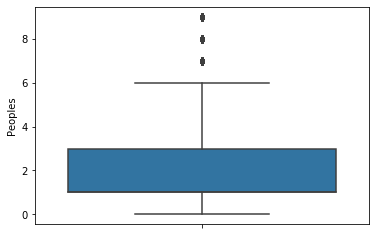

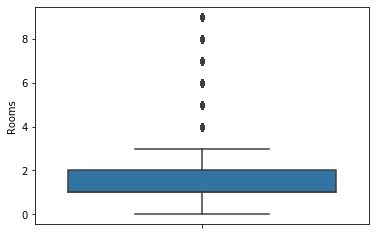

In [200]:
sns.boxplot(y="Supply", data=ds_sdsd_2)
plt.show()
sns.boxplot(y="2019", data=ds_sdsd_2)
plt.show()
sns.boxplot(y="LastMonth", data=ds_sdsd_2)
plt.show()
sns.boxplot(y="Peoples", data=ds_sdsd_2)
plt.show()
sns.boxplot(y="Rooms", data=ds_sdsd_2)
plt.show()

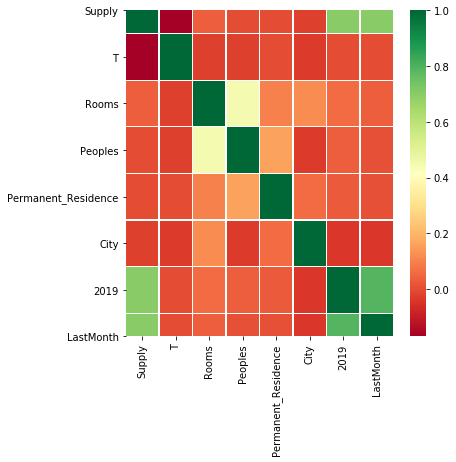

In [201]:
f, ax = plt.subplots(figsize=(6, 6))
corr = np.round_(ds_sdsd_2.corr(), decimals=2)
sns.heatmap(corr,annot=False,cmap='RdYlGn',linewidths=0.2)

Линейная регрессия

In [203]:
X_train, X_test, y_train, y_test = train_test_split(ds_sdsd_2[['T', 'Rooms', 'Peoples', 'Permanent_Residence','City','2019','LastMonth']], ds_sdsd_2['Supply'], test_size=0.3)
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [204]:
r_train = model.score(X_train, y_train)
r_test = model.score(X_test, y_test)
print('Качество модели на тестовых данных:', r_test, '\nКачество модели на тренировочных данных:', r_train)

Качество модели на тестовых данных: 0.5867635213355691 
Качество модели на тренировочных данных: 0.5802929357844289


### Выводы: результаты гораздо лучше, чем на модели без добавления признаков: выросли с 0.033 до 0.587!

Случайный лес

In [205]:
X_train, X_test, y_train, y_test = train_test_split(ds_sdsd_2[['T', 'Rooms', 'Peoples', 'Permanent_Residence','City','2019','LastMonth']], ds_sdsd_2['Supply'], test_size=0.3)
model_rf=RandomForestRegressor(n_estimators=100, max_features='auto', n_jobs=4, random_state=1)
model_rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=4, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

In [206]:
model_pred = model_rf.predict(X_test)
print('Mean Absolute Error (MAE):', mean_absolute_error(y_test, model_pred))
print('Mean Squared Error (MSE):', mean_squared_error(y_test, model_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(y_test, model_pred)))
mape = np.mean(np.abs((y_test - model_pred) / np.abs(y_test)))
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
print('Accuracy:', round(100*(1 - mape), 2))
print('Model score:', model_rf.score(X_test, y_test))

Mean Absolute Error (MAE): 111.65453266547664
Mean Squared Error (MSE): 71878.2216643781
Root Mean Squared Error (RMSE): 268.1011407368087
Mean Absolute Percentage Error (MAPE): 180.41
Accuracy: -80.41
Model score: 0.7529172501282467


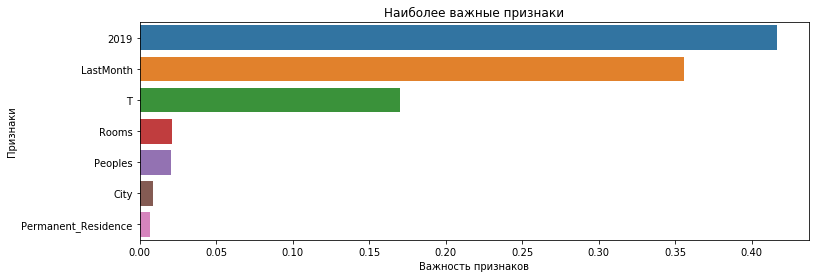

In [207]:
headers = list(X_train.columns.values)
feature_imp = pd.Series(model_rf.feature_importances_,index=headers).sort_values(ascending=False)
f, ax = plt.subplots(figsize=(12, 4))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Важность признаков')
plt.ylabel('Признаки')
plt.title("Наиболее важные признаки")
plt.show()

### Выводы: результаты гораздо лучше, чем на модели без добавления признаков!
- Mean Absolute Error (MAE): 112 (было: 305)
- Mean Squared Error (MSE): 71878 (281476)
- Root Mean Squared Error (RMSE): 268 (530)
- Mean Absolute Percentage Error (MAPE): 180 (1695)
- Accuracy: -80 (-1595)
- Model score: 0.75 (0.041)

Оптимизация модели Случайного леса

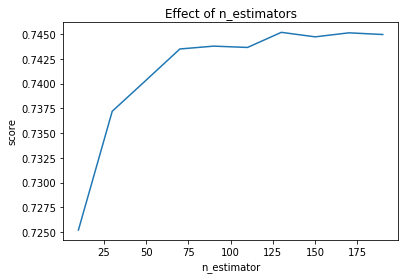

In [208]:
X_train, X_test, y_train, y_test = train_test_split(ds_sdsd_2[['T', 'Rooms', 'Peoples', 'Permanent_Residence','City','2019','LastMonth']], ds_sdsd_2['Supply'], test_size=0.3)
model_test=RandomForestRegressor()
estimators = np.arange(10, 200, 20)
scores = []
for n in estimators:
    model_test.set_params(n_estimators=n)
    model_test.fit(X_train, y_train)
    scores.append(model_test.score(X_test, y_test))
plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("score")
plt.plot(estimators, scores)

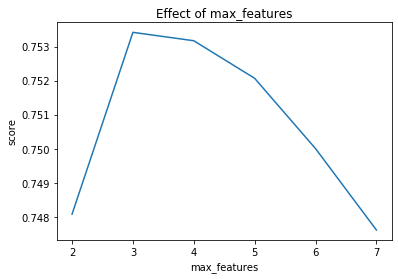

In [209]:
X_train, X_test, y_train, y_test = train_test_split(ds_sdsd_2[['T', 'Rooms', 'Peoples', 'Permanent_Residence','City','2019','LastMonth']], ds_sdsd_2['Supply'], test_size=0.3)
model_test=RandomForestRegressor()
features = np.arange(2, 8, 1)
scores = []
for f in features:
    model_test.set_params(n_estimators=125, max_features=f)
    model_test.fit(X_train, y_train)
    scores.append(model_test.score(X_test, y_test))
plt.title("Effect of max_features")
plt.xlabel("max_features")
plt.ylabel("score")
plt.plot(features, scores)

In [94]:
# потом посмотреть
"""
def rfr_model(X, y):# Perform Grid-Search
    gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (10, 50, 100, 1000),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    
    rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"], random_state=False, verbose=False)# Perform K-Fold CV   
    scores = cross_val_score(rfr, X, y, cv=10, scoring='neg_mean_absolute_error')

    return scores

scores = cross_val_score(rfr, X, y, cv=10, scoring='neg_mean_absolute_error')
predictions = cross_val_predict(rfr, X, y, cv=10)
"""

NameError: name 'rfr' is not defined

In [121]:
# df.to_excel('results.xlsx')